In [1]:
from backend.models.model_nnext import ModelNNext
from configs.config import get_cfg
import matplotlib.pyplot as plt

cfg = get_cfg("model_finance.yaml")

# Instantiate and print the model
model = ModelNNext(cfg)
model.run_sequence()

[*********************100%***********************]  5 of 5 completed


Finished epoch 0, latest loss: 4.757076263427734.
Finished epoch 1, latest loss: 4.7205352783203125.
Finished epoch 2, latest loss: 4.4896416664123535.
Finished epoch 3, latest loss: 4.218481540679932.
Finished epoch 4, latest loss: 4.0848798751831055.
Finished epoch 5, latest loss: 4.264396667480469.
Finished epoch 6, latest loss: 4.239121913909912.
Finished epoch 7, latest loss: 3.3116955757141113.
Finished epoch 8, latest loss: 2.849541664123535.
Finished epoch 9, latest loss: 2.7435193061828613.
Finished epoch 10, latest loss: 3.4424855709075928.
Finished epoch 11, latest loss: 2.5261192321777344.
Finished epoch 12, latest loss: 2.435742139816284.
Finished epoch 13, latest loss: 2.512855052947998.
Finished epoch 14, latest loss: 2.461812734603882.
Finished epoch 15, latest loss: 2.3803157806396484.
Finished epoch 16, latest loss: 2.0846481323242188.
Finished epoch 17, latest loss: 2.31925106048584.
Finished epoch 18, latest loss: 2.103955030441284.
Finished epoch 19, latest loss: 2

[[-0.3384236   0.02357543 -0.08749367 -0.01934429  0.49734604]
 [ 0.44183958 -0.22463578 -0.19721253 -0.1689704  -0.47341716]
 [ 0.08978549  0.79928315  0.2551429   0.25960687 -0.29970238]
 ...
 [ 2.3889542   3.0299416   3.0621629   1.9389123   0.49779743]
 [-0.7805778  -1.3045907  -0.6522387  -0.79786026 -2.4057798 ]
 [-0.11555468  0.22716475  0.14243075  0.16614072  0.84098876]]


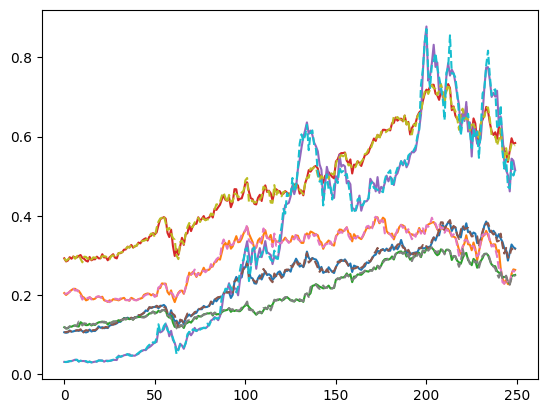

In [3]:
Ypred = model.evaluate(model.data.X_test_set.reshaped_2D_tensor()).numpy()
Ytrue = model.data.Y_test_set.ndarray
floorYtest = model.data.Ybis_test_set.ndarray

print(Ypred)
Ypred= (Ypred/100+1)*floorYtest
Ytrue= (Ytrue/100+1)*floorYtest

plt.plot(Ypred)
plt.plot(Ytrue, '--')

# # plt.plot(range(n2,n1),full_pred_series,alpha = 0.7, linestyle='--')
plt.show()